<hr style="border-width:4px;border-color:coral" />

# Solving the 2d heat equation using CUDA

<hr style="border-width:4px;border-color:coral" />

This notebook follows the previous notebook on solving the heat equation.   

* <a href="#plotting">Plot the initial conditions</a>

* <a href="#timesteps">Plot the time steps</a>

This note book also provides a template for how to plot data from your heat equation. This code will work for either serial or parallel output.

In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


## Using CUDA to update the solution

The simplest approach to using a GPU for the heat equation is to use CUDA to update the solution.  We can use our original serial heat2d code, and replace the explicit update using the Forward Euler scheme with a scheme that uses threads to update each cell. 

The code looks very similar to our more familar C code for the heat update. 

In [2]:
%%file heat2d_update_global.cu


#include <stdio.h>

__global__ void setup_arrays2d_cuda(int Nx, int Ny, int mbc, 
                                    double *qmem, double** qrows, double*** q)
{
    int rows = Nx + 1 + 2*mbc;
    int cols = Ny + 1 + 2*mbc; 

    for(int i = 0; i < rows; i++)
    {
        qrows[i] = &qmem[cols*i + mbc];
    }    
    *q = &qrows[mbc];
}


__global__ void heat2d_update(int Nx, int Ny, int mbc, double dx2, double dy2,
                              double dt, double ***dev_q, double ***dev_qp)
{
    double **q = *dev_q;
    double **qp = *dev_qp;

    int i = blockIdx.x*blockDim.x + threadIdx.x; 
    int j = blockIdx.y*blockDim.y + threadIdx.y; 

    if (i <= Nx && j <= Ny)
    {
        double qij = q[i][j];
        double qxx = (q[i-1][j] - 2*qij + q[i+1][j])/dx2;
        double qyy = (q[i][j-1] - 2*qij + q[i][j+1])/dy2;
        qp[i][j] = qij + dt*(qxx + qyy);
    }
}

Overwriting heat2d_update_global.cu


In [19]:
%%bash

rm -rf heat2d
rm -rf heat2d.out

nvcc -o heat2d -O2 heat2d_cuda.cu heat2d_update_global.cu

# Redhawk
time srun --nodelist=node1 heat2d 256 256 10


real	0m3.770s
user	0m0.010s
sys	0m0.014s


In [13]:
%%file heat2d_update_shared.cu


#include <stdio.h>

__global__ void setup_arrays2d_cuda(int Nx, int Ny, int mbc, 
                                    double *qmem, double** qrows, double*** q)
{
    int rows = Nx + 1 + 2*mbc;
    int cols = Ny + 1 + 2*mbc; 

    for(int i = 0; i < rows; i++)
    {
        qrows[i] = &qmem[cols*i + mbc];
    }    
    *q = &qrows[mbc];
}

#define MAX_SHARED_MEMORY 1000

__global__ void heat2d_update(int Nx, int Ny, int mbc, double dx2, double dy2,
                              double dt, double ***dev_q, double ***dev_qp)
{
    extern __shared__ double shared_mem[];

    __shared__ double *qmem, **qrows_shared, **qs;
    __shared__ double **q;
    __shared__ double **qp;

    if (threadIdx.x == 0 && threadIdx.y == 0)
    {
        q = *dev_q;
        qp = *dev_qp;

        int I = blockIdx.x*blockDim.x;
        int J = blockIdx.y*blockDim.y;

        int rows = (blockDim.x + 1 + 2*mbc);
        int cols = (blockDim.y + 1 + 2*mbc);

        qmem          = (double*)  &shared_mem[0];
        qrows_shared  = (double**) &shared_mem[rows*cols];
        
        for(int i = 0; i < rows; i++)
        {
            qrows_shared[i] = &qmem[cols*i + mbc] - J;
        }    
        qs = &qrows_shared[mbc] - I;        
    }
    __syncthreads();
    
    int i = blockIdx.x*blockDim.x + threadIdx.x; 
    int j = blockIdx.y*blockDim.y + threadIdx.y; 

    if (i <= Nx &&  j <= Ny)
        qs[i][j] = q[i][j];
    
    __syncthreads();
    

    if (i <= Nx && j <= Ny)
    {
        double qij = qs[i][j];
        double qxx = (q[i-1][j] - 2*qij + q[i+1][j])/dx2;
        double qyy = (q[i][j-1] - 2*qij + q[i][j+1])/dy2;
        qp[i][j] = qij + dt*(qxx + qyy);
    }
}

Overwriting heat2d_update_shared.cu


In [14]:
%%bash

rm -rf heat2d
rm -rf heat2d.out

nvcc -o heat2d -O2 heat2d_cuda.cu heat2d_update_shared.cu

# Redhawk
time srun --nodelist=node1 heat2d 256 256 10


real	0m5.791s
user	0m0.013s
sys	0m0.011s


In [ ]:
%%bash 

rm -rf heat2d_serial 
rm -rf heat2d_serial.out

gcc -o heat2d_serial -O2 heat2d_serial.c -lm

# time srun heat2d_serial 512 512 10

## Read meta data

Meta data is stored by the executable and read in here.  It is a good idea to check that everything that was read in is correct and agrees with what you expect.  

In [20]:
# Open file for reading; use binary mode
fout = open("heat2d.out","rb")

# Read meta data
dt_meta = dtype([('Nx','int32'),('Ny','int32'),('ax','d'),('bx','d'), \
                 ('ay','d'),('by','d'),('M','int32')])
d = fromfile(fout,dtype=dt_meta, count=1)[0]

# create dictionary containing meta data
parms = {}
for i,k in enumerate(dt_meta.fields):
    parms[k] = d[k]

# Print meta data from dictionary
print("Mesh cell dimensions : ({Nx:2d},{Ny:2d})".format(**parms))
print("")
print("Domain : [{ax:g},{bx:g}] x [{ay:g},{by:g}]".format(**parms))
print("")
print("Total number of time steps : {M:d}".format(**parms))
print("")

# Assign values in tuple directly (for use below)
Nx,Ny,ax,bx,ay,by,M = d

# Read solution data and count number of output steps.  This should match number
# set by the user in call to `heat2d`
dt_heat = dtype([('t','d'),('q','d',(Nx+1)*(Ny+1))])  
data = fromfile(fout,dtype=dt_heat)
Mout = len(data) # Number of time steps output.
print("Number of output steps : {:d}".format(Mout))

# Close file
fout.close()

Mesh cell dimensions : (256,256)

Domain : [-1,1] x [-1,1]

Total number of time steps : 6900

Number of output steps : 10


## Create the 2d mesh

We create a 2d mesh needed for plotting. 

In [21]:
xe = linspace(ax,bx,Nx+1)
ye = linspace(ay,by,Ny+1)

dx = (bx-ax)/Nx
dy = (by-ay)/Ny

[xm,ym] = meshgrid(xe,ye)

<a id="plotting"></a>

<hr style="border-width:4px; border-color:coral"></hr>

## Plot the initial conditions

<hr style="border-width:4px; border-color:coral"></hr>

<IPython.core.display.Javascript object>


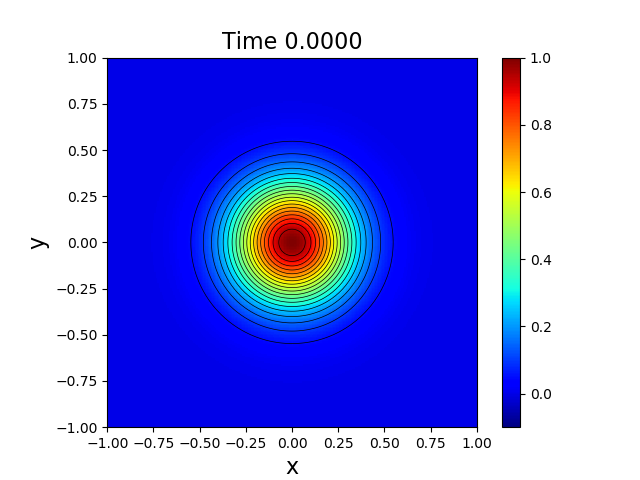

In [22]:
# Plot initial conditions
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

figure(1)
clf()

set_cmap('jet')


q = reshape(data[0][1],(Nx+1,Ny+1))
mesh = pcolormesh(xm,ym,q,vmin=-0.1,vmax=1)

cv = linspace(0,1,21)
cv = cv[1:]   # avoid 0 contours
cont = contour(xm,ym,q,colors='k',levels=cv,linewidths=0.5)

gca().set_aspect(1)

title('Time {:0.4f}'.format(0),fontsize=16)
xlabel('x',fontsize=16)
ylabel('y', fontsize=16)

colorbar(mesh)

show()

<a id="timesteps"></a>

<hr style="border-width:4px; border-color:coral"></hr>

## Plot the solution in time

<hr style="border-width:4px; border-color:coral"></hr>

<IPython.core.display.Javascript object>


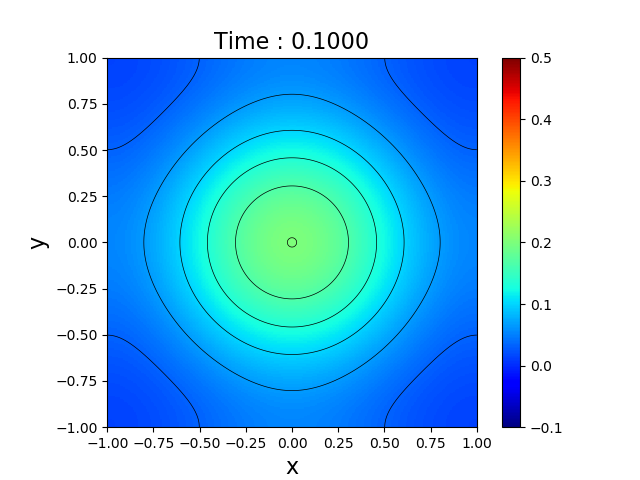

qmax =   2.00259020e-01
qmin =   1.46490323e-02


In [23]:
# Plot initial solution and store handle
fig = figure(2)
clf()

q = reshape(data[0][1],(Nx+1,Ny+1))
mesh = pcolormesh(xm,ym,q,shading='flat',vmin=-0.1,vmax=0.5)
#mesh = pcolormesh(xm,ym,q,shading='flat',vmin=-1,vmax=9*9-1)

    
# Set up contour lines
cv = linspace(0,1,31)
cv = cv[1:]   # avoid 0 contours
cont = contour(xm,ym,q,colors='k',levels=cv,linewidths=0.5)

# Add title, axis labels, etc
htitle = title('Time : {:.4f}'.format(0),fontsize=16)
xlabel('x',fontsize=16)
ylabel('y', fontsize=16) 

colorbar(mesh)

# Make axis square
gca().set_aspect(1)

# Refresh plot
fig.canvas.draw()     

pause(0.1)

for n in range(0,Mout):

    t = data[n][0]
    
    q = reshape(data[n][1],(Nx+1,Ny+1))
    #q = data[n][1]
    mesh.set_array(q[:-1,:-1].ravel())

    # Plot contour lines
    for c in cont.collections:
       c.remove()
    cont = contour(xm,ym,q,colors='k',levels=cv,linewidths=0.5)

    # Update title with new time
    htitle.set_text('Time : {:.4f}'.format(t))

    # Make axis square
    gca().set_aspect(1)

    # Refresh plot
    fig.canvas.draw()        
    
    pause(0.1)
    
print("qmax = {:16.8e}".format(q.max()))
print("qmin = {:16.8e}".format(q.min()))

In [ ]:
q

In [ ]:
class block:
    def __init__(self,x,y):
        self.x = x
        self.y = y
    
class grid:
    def __init__(self,x,y):
        self.x = x
        self.y = y

Nx = 16
Ny = 16
msize = Nx + 1
nsize = Ny + 1
b = block(8,8)
g = grid((msize+b.x - 1)//b.x, (nsize+b.y - 1)//b.y)

thread_index
